# Data Valuation for Fraud Detection

In [7]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import seaborn as sns

# Load processed data
X_train, X_test, y_train, y_test = joblib.load('../data/processed/processed_data.joblib')

## Leave-One-Out Influence Analysis

In [4]:
# We'll use a subset for this analysis due to computational constraints
sample_idx = np.random.choice(X_train.index, size=1000, replace=False)
X_sample = X_train.loc[sample_idx]
y_sample = y_train.loc[sample_idx]

# Train base model on full sample
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_sample, y_sample)
base_score = roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])

# Calculate leave-one-out influences
influences = []

for idx in tqdm(sample_idx):
    # Train model without this instance
    X_loo = X_sample.drop(idx)
    y_loo = y_sample.drop(idx)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_loo, y_loo)
    
    # Calculate score difference
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    influence = base_score - score
    influences.append(influence)

# Add to dataframe
influence_df = pd.DataFrame({
    'index': sample_idx,
    'influence': influences,
    'class': y_sample
})

# Save results
influence_df.to_csv('../data/processed/loo_influence.csv', index=False)

100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


## Influence Analysis Results

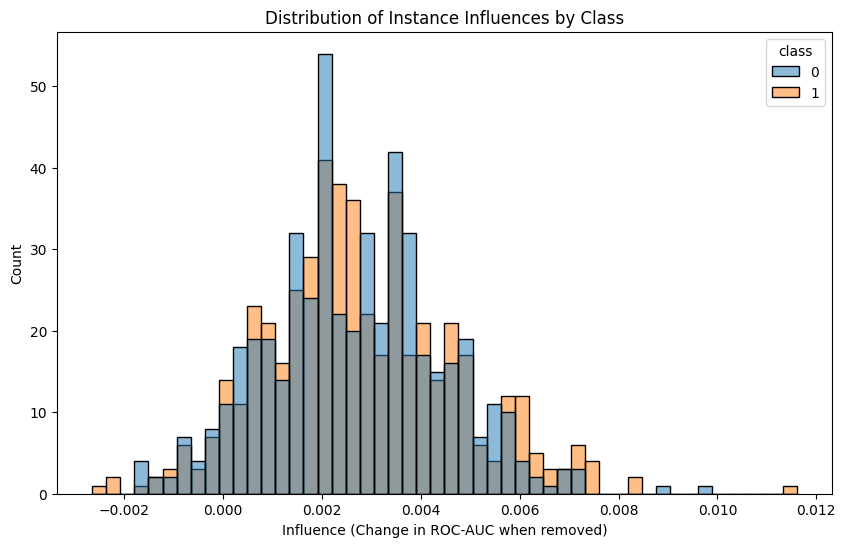

In [8]:
# Plot distribution of influences
plt.figure(figsize=(10, 6))
sns.histplot(data=influence_df, x='influence', hue='class', bins=50)
plt.title('Distribution of Instance Influences by Class')
plt.xlabel('Influence (Change in ROC-AUC when removed)')
plt.ylabel('Count')
plt.show()

## Most Influential Instances

In [9]:
# Show top positive influences (instances that hurt performance when removed)
print("Top Positive Influences (Important instances):")
print(influence_df.sort_values('influence', ascending=False).head(10))

Top Positive Influences (Important instances):
         index  influence  class
366509  366509   0.011602      1
220529  220529   0.009864      0
114638  114638   0.008783      0
372859  372859   0.008462      1
387833  387833   0.008457      1
275876  275876   0.007574      1
285049  285049   0.007574      1
336451  336451   0.007498      1
248930  248930   0.007358      1
414579  414579   0.007306      1


## Data Valuation with KNN Shapley

In [11]:
# Simplified KNN-Shapley approximation
from sklearn.neighbors import KNeighborsClassifier

# We'll use a smaller subset for this
knn_sample_idx = np.random.choice(X_train.index, size=500, replace=False)
X_knn = X_train.loc[knn_sample_idx]
y_knn = y_train.loc[knn_sample_idx]

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_knn, y_knn)

# Get nearest neighbors for test instances
test_probas = knn.predict_proba(X_test)
test_preds = (test_probas[:, 1] > 0.5).astype(int)

# Calculate marginal contributions
shapley_values = np.zeros(len(X_knn))

for i, (idx, row) in enumerate(X_knn.iterrows()):
    # Remove this instance
    X_minus_i = X_knn.drop(idx)
    y_minus_i = y_knn.drop(idx)
    
    # Retrain without this instance
    knn_minus_i = KNeighborsClassifier(n_neighbors=5)
    knn_minus_i.fit(X_minus_i, y_minus_i)
    
    # Calculate difference in predictions
    probas_minus_i = knn_minus_i.predict_proba(X_test)
    preds_minus_i = (probas_minus_i[:, 1] > 0.5).astype(int)
    
    # Marginal contribution is accuracy difference
    acc_full = (test_preds == y_test).mean()
    acc_minus_i = (preds_minus_i == y_test).mean()
    shapley_values[i] = acc_full - acc_minus_i

# Add to dataframe
shapley_df = pd.DataFrame({
    'index': X_knn.index,
    'shapley_value': shapley_values,
    'class': y_knn
})

# Save results
shapley_df.to_csv('../data/processed/knn_shapley.csv', index=False)

## Shapley Value Analysis

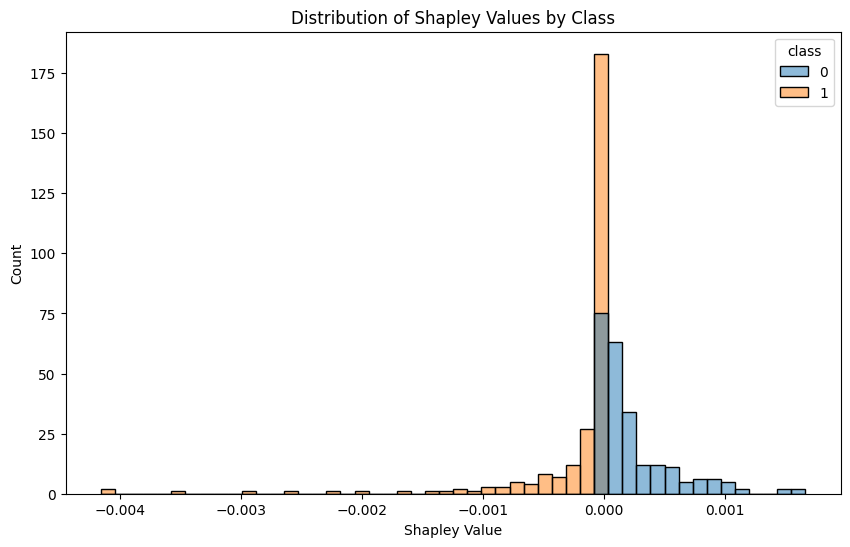

In [12]:
# Plot distribution of Shapley values
plt.figure(figsize=(10, 6))
sns.histplot(data=shapley_df, x='shapley_value', hue='class', bins=50)
plt.title('Distribution of Shapley Values by Class')
plt.xlabel('Shapley Value')
plt.ylabel('Count')
plt.show()

## Most Valuable Instances

In [13]:
# Show top instances by Shapley value
print("Top Valuable Instances:")
print(shapley_df.sort_values('shapley_value', ascending=False).head(10))

Top Valuable Instances:
         index  shapley_value  class
24691    24691       0.001668      0
91760    91760       0.001633      0
48144    48144       0.001457      0
168216  168216       0.001440      0
155671  155671       0.001194      0
114482  114482       0.001106      0
45325    45325       0.001053      0
4788      4788       0.001036      0
55469    55469       0.001018      0
30442    30442       0.001001      0
